In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D

In [9]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]  # Fixed slicing syntax
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [10]:
def plot(path_XYs, colors=None):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    if colors is None:
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'black']
    for i, XYs in enumerate(path_XYs):
        c = colors[i % len(colors)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

In [11]:
def extract_features(path_XYs):
    features = []
    for paths in path_XYs:
        for path in paths:
            distances = np.linalg.norm(np.diff(path, axis=0), axis=1)
            angles = np.arctan2(np.diff(path[:, 1]), np.diff(path[:, 0]))
            features.append([np.mean(distances), np.std(distances), np.mean(angles), np.std(angles)])
    features = np.array(features)
    return features

In [12]:
def regularize_curves(path_XYs, n_clusters=3):
    features = extract_features(path_XYs)
    if features.shape[0] < n_clusters:
        raise ValueError(f"Number of samples ({features.shape[0]}) should be >= number of clusters ({n_clusters})")
    kmeans = KMeans(n_clusters=n_clusters).fit(features)
    labels = kmeans.labels_
    return labels

In [13]:
def build_symmetry_detection_model():
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(374, 2)),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Symmetrical (1) or not (0)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
def train_symmetry_detection_model(model, curves, labels, epochs=10, batch_size=32):
    model.fit(curves, labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

In [15]:
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 23, input_dim=100))
    model.add(Reshape((23, 128)))
    model.add(Conv1DTranspose(64, 4, strides=2, padding='same', activation='relu'))
    model.add(Conv1DTranspose(32, 4, strides=2, padding='same', activation='relu'))
    model.add(Conv1D(1, 7, padding='same', activation='sigmoid'))
    return model

In [16]:
def build_discriminator():
    model = Sequential()
    model.add(Conv1D(64, 4, strides=2, padding='same', input_shape=(374, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [17]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [18]:
def preprocess_curves(curves, target_length=100):
    processed_curves = []
    for curve in curves:
        if curve.shape[0] < target_length:
            # Pad the curve with zeros
            padded_curve = np.pad(curve, ((0, target_length - curve.shape[0]), (0, 0)), mode='constant')
        else:
            # Truncate the curve
            padded_curve = curve[:target_length]
        processed_curves.append(padded_curve)
    return np.array(processed_curves)

In [19]:
def create_incomplete_curves(path_XYs, mask_fraction=0.2, target_length=374):
    incomplete_curves = []
    complete_curves = []

    for curves in path_XYs:
        for curve in curves:
            # Create a mask to simulate missing parts
            mask = np.random.rand(curve.shape[0]) > mask_fraction
            incomplete_curve = curve.copy()
            incomplete_curve[~mask] = np.nan

            # Pad or truncate the curve to target_length
            incomplete_curve = np.pad(incomplete_curve, ((0, max(0, target_length - incomplete_curve.shape[0])), (0, 0)), mode='constant', constant_values=np.nan)[:target_length]
            complete_curve = np.pad(curve, ((0, max(0, target_length - curve.shape[0])), (0, 0)), mode='constant')[:target_length]

            incomplete_curves.append(incomplete_curve)
            complete_curves.append(complete_curve)

    return list(zip(incomplete_curves, complete_curves))

In [20]:
def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(input_img)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)

    # Flatten and Dense layer
    x = layers.Flatten()(x)
    encoded = layers.Dense(256, activation='relu')(x)

    # Decoder
    x = layers.Dense(256 * (input_shape[0] // 16), activation='relu')(encoded)
    x = layers.Reshape((input_shape[0] // 16, 256))(x)

    x = layers.UpSampling1D(2)(x)  # Upsample to (x // 8, 256)
    x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # Upsample to (x // 4, 128)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # Upsample to (x // 2, 64)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # Upsample to (x, 32)
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(x)

    # Final layer to ensure the output shape matches the input shape
    decoded = layers.Conv1D(input_shape[1], 3, padding='same', activation='sigmoid')(x)  # Output shape matches input shape

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [21]:
def normalize_data(curves):
    # Normalize data to [0, 1] range
    min_val = np.nanmin(curves)
    max_val = np.nanmax(curves)
    normalized_curves = (curves - min_val) / (max_val - min_val)
    return normalized_curves

In [22]:
def train_autoencoder(autoencoder, data, epochs=50, batch_size=16):
    incomplete_curves, complete_curves = zip(*data)

    incomplete_curves = np.array(incomplete_curves)
    complete_curves = np.array(complete_curves)

    # Normalize the data
    incomplete_curves = normalize_data(incomplete_curves)
    complete_curves = normalize_data(complete_curves)

    # Reduce the target shape from 374 to 368
    complete_curves = complete_curves[:, :368, :]

    # Train the autoencoder
    autoencoder.fit(incomplete_curves, complete_curves,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2)

In [23]:
def get_max_curve_length(path_XYs):
    return max(len(curve) for curves in path_XYs for curve in curves)

In [24]:
def print_shapes(model):
    for layer in model.layers:
        print(layer.name, layer.output_shape)

In [25]:
def get_reconstructed_curves(autoencoder, incomplete_curves):
    normalized_incomplete_curves = normalize_data(np.array(incomplete_curves))
    reconstructed_curves = autoencoder.predict(normalized_incomplete_curves)
    return reconstructed_curves

In [26]:
def plot_reconstructed_curves(incomplete_curves, complete_curves, reconstructed_curves, num_samples=5):
    # Adjust num_samples to be within the bounds of available data
    num_samples = min(num_samples, len(incomplete_curves))

    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples), tight_layout=True)

    for i in range(num_samples):
        # Plot incomplete curve
        axs[i, 0].plot(incomplete_curves[i][:, 0], incomplete_curves[i][:, 1], color='gray', label='Incomplete')
        axs[i, 0].set_title(f'Incomplete Curve {i+1}')
        axs[i, 0].legend()

        # Plot complete curve
        axs[i, 1].plot(complete_curves[i][:, 0], complete_curves[i][:, 1], color='blue', label='Complete')
        axs[i, 1].set_title(f'Complete Curve {i+1}')
        axs[i, 1].legend()

        # Plot reconstructed curve
        axs[i, 2].plot(reconstructed_curves[i][:, 0], reconstructed_curves[i][:, 1], color='red', label='Reconstructed')
        axs[i, 2].set_title(f'Reconstructed Curve {i+1}')
        axs[i, 2].legend()

    plt.show()

In [27]:
def complete_curve(curve, autoencoder, symmetry_model):
    # Detect symmetry
    is_symmetrical = symmetry_model.predict(np.expand_dims(curve, axis=0))[0, 0] > 0.5

    if is_symmetrical:
        # Complete the curve using the autoencoder
        normalized_curve = normalize_data(np.expand_dims(curve, axis=0))
        reconstructed_curve = autoencoder.predict(normalized_curve)[0]
        return reconstructed_curve
    else:
        return curve  # Return as is if not symmetrical

"/content/drive/MyDrive/occlusion1.csv"

'/content/drive/MyDrive/occlusion1.csv'

In [28]:
def complete_missing_curves(curves, autoencoder, symmetry_model):
    completed_curves = [complete_curve(curve, autoencoder, symmetry_model) for curve in curves]
    return completed_curves

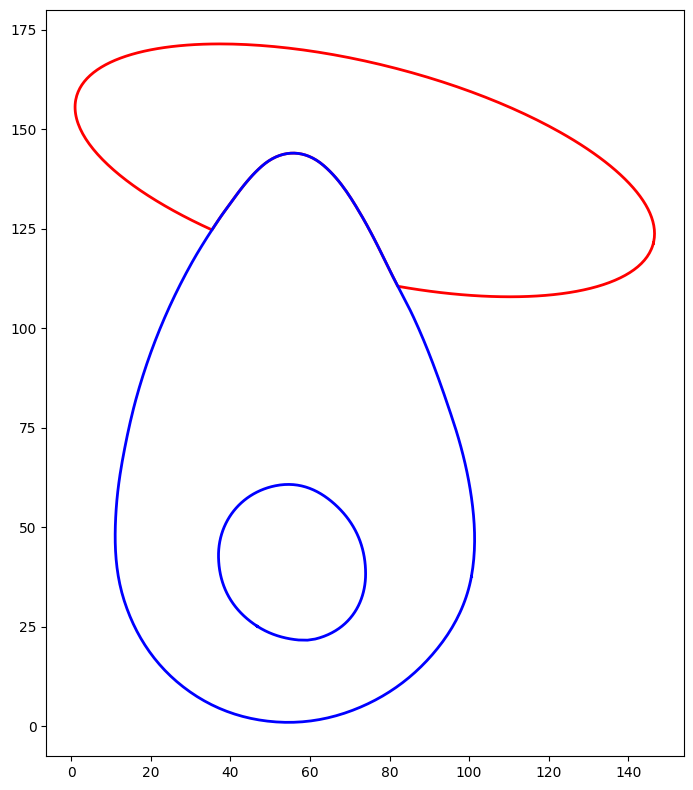

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 374, 2)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_24 (Conv1D)                   │ (None, 374, 32)             │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 187, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 187, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 94, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 94, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 47, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 47, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6144)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       1,573,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5888)                │       1,513,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 23, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_8 (UpSampling1D)       │ (None, 46, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_28 (Conv1D)                   │ (None, 46, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_9 (UpSampling1D)       │ (None, 92, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_29 (Conv1D)                   │ (None, 92, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_10 (UpSampling1D)      │ (None, 184, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_30 (Conv1D)                   │ (None, 184, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_11 (UpSampling1D)      │ (None, 368, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 368, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,542,338 (13.51 MB)

 Trainable params: 3,542,338 (13.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: nan - val_loss: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: nan - val_loss: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: nan - val_loss: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: nan - val_loss: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: nan - val_loss: nan
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: nan - val_loss: nan
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: nan - val_loss: nan
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: nan - val_loss: nan
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: nan - val_loss: nan
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: nan - val_loss: nan
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: nan - val_loss: nan
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: nan - val_loss: nan
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: nan - 

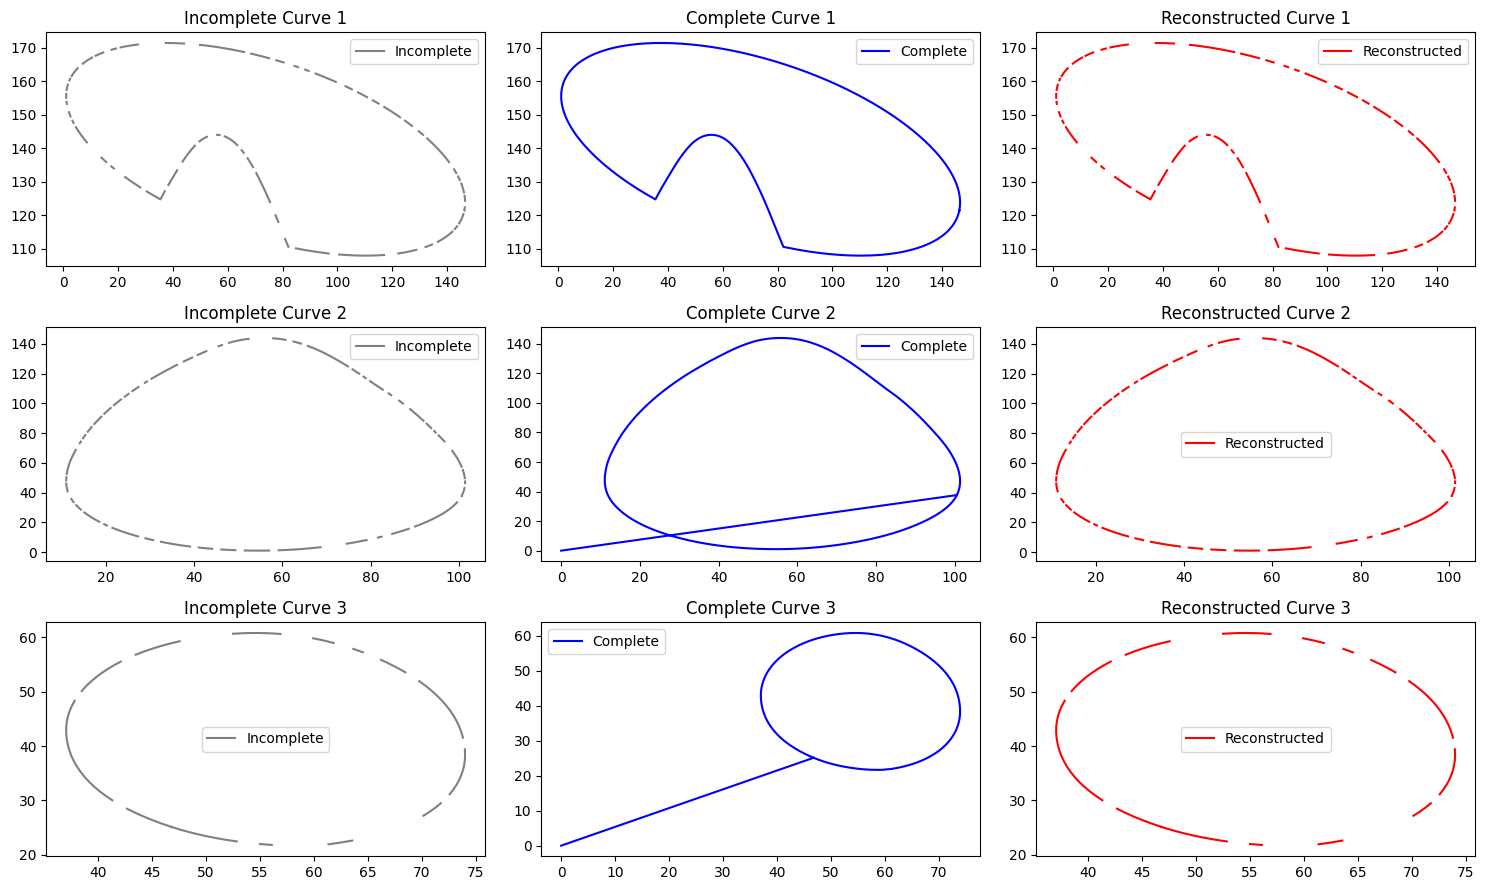

In [29]:
if __name__ == "__main__":
    # Load and preprocess the data
    data_path = "/content/occlusion1.csv"
    path_XYs = read_csv(data_path)

    # Visualize the data
    plot(path_XYs)

    # Create incomplete curves
    data = create_incomplete_curves(path_XYs)

    # Extract features for symmetry detection
    incomplete_curves, complete_curves = zip(*data)
    curves = np.array(incomplete_curves)
    labels = np.array([1 if np.random.rand() > 0.5 else 0 for _ in curves])  # Dummy labels, replace with actual labels

    # Train the symmetry detection model
    symmetry_model = build_symmetry_detection_model()
    train_symmetry_detection_model(symmetry_model, curves, labels)

    # Build and train the autoencoder
    max_length = get_max_curve_length(path_XYs)
    input_shape = (max_length, 2)
    autoencoder = build_autoencoder(input_shape)
    autoencoder.summary()
    train_autoencoder(autoencoder, data, epochs=50, batch_size=16)

    # Complete curves
    completed_curves = complete_missing_curves(incomplete_curves, autoencoder, symmetry_model)

    # Plot results
    plot_reconstructed_curves(incomplete_curves, complete_curves, completed_curves)